In [63]:
import pywt
import scipy
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

In [64]:
def low_pass_filter(data, threshold = 1): # the flter cut off frequencies over the threshold
    # Create the low pass butterworth filter that will filter at a frequency equal to the threshold
    b, a = scipy.signal.butter(8, threshold, 'low', fs=52)
    # Apply the filter to the data
    data['X'] = scipy.signal.filtfilt(b, a, data['X'])
    data['Y'] = scipy.signal.filtfilt(b, a, data['Y'])
    data['Z'] = scipy.signal.filtfilt(b, a, data['Z'])
    return data

def preprocess_data(data, fs=52, low_pass=False, low_pass_freq=1):
    new_data = data[['Time', 'X', 'Y', 'Z']].copy()

    if 'Sec' in data.columns:
        new_data['Time'] = data['Sec']
    else:
        # Compute time based on the sampling frequency of 52 Hz
        sample_numbers = np.arange(len(data))
        time = sample_numbers / fs  # Time in seconds
        new_data['Time'] = time

    # Scale the data in range 0-1
    scaler = StandardScaler()
    new_data[['X', 'Y', 'Z']] = scaler.fit_transform(new_data[['X', 'Y', 'Z']])

    if low_pass:
        new_data = low_pass_filter(new_data, threshold=low_pass_freq)
    return new_data

In [65]:
def plot_time_series(data, activity):
    """
    Plots the 3 channels of the time series data.

    Parameters:
    data (pandas.DataFrame): The time series data.
    activity (str): The activity name to be used in the title.
    """
    # Create subplots
    fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

    # Plot X-axis acceleration
    axes[0].plot(data['Time'], data['X'], color='r', label="X-axis")
    axes[0].set_ylabel("Acceleration (X)")
    axes[0].legend()
    axes[0].grid()

    # Plot Y-axis acceleration
    axes[1].plot(data['Time'], data['Y'], color='g', label="Y-axis")
    axes[1].set_ylabel("Acceleration (Y)")
    axes[1].legend()
    axes[1].grid()

    # Plot Z-axis acceleration
    axes[2].plot(data['Time'], data['Z'], color='b', label="Z-axis")
    axes[2].set_xlabel("Time (s)")
    axes[2].set_ylabel("Acceleration (Z)")
    axes[2].legend()
    axes[2].grid()

    # Title for the whole figure
    plt.suptitle(f"Accelerometer Time Series ({activity})")

    # Show plot
    plt.show()

In [66]:
def plot_cwt_spectrograms(data, wavelet, activity, fs=52, freq_min=1, freq_max=26, fc=0.25):
    """
    Plots the Continuous Wavelet Transform (CWT) spectrograms for the given time series data.

    Parameters:
    data (pandas.DataFrame): The time series data with columns 'Time', 'X', 'Y', and 'Z'.
    wavelet (str): The wavelet to use for CWT (e.g., 'mexh' for Mexican Hat).
    activity (str): The activity name to be used in the title.
    fs (float): The sampling frequency in Hz. Default is 52 Hz.
    """
    # Define scales and frequencies for CWT
    f_min, f_max = freq_min, freq_max  # Min and max frequencies for CWT

    # Convert frequencies to scales
    scales = fc * fs / np.array([f_max, f_min])
    scales = np.linspace(scales[0], scales[1], num=100)  # 100 scales

    # Perform CWT for each signal
    coeff_x, freq_x = pywt.cwt(data['X'], scales, wavelet, sampling_period=1/fs)
    coeff_y, freq_y = pywt.cwt(data['Y'], scales, wavelet, sampling_period=1/fs)
    coeff_z, freq_z = pywt.cwt(data['Z'], scales, wavelet, sampling_period=1/fs)

    # Plot CWT spectrograms (scalograms)
    fig, axes = plt.subplots(3, 1, figsize=(12, 9), sharex=True)

    # X-axis scalogram
    cax_x = axes[0].imshow(np.abs(coeff_x), aspect='auto', extent=[data['Time'].min(), data['Time'].max(), freq_x.max(), freq_x.min()], cmap='jet')
    axes[0].set_title("CWT Scalogram - X Axis")
    axes[0].set_ylabel("Frequency (Hz)")
    axes[0].grid()
    fig.colorbar(cax_x, ax=axes[0], orientation='vertical', label='Coefficient Magnitude')

    # Y-axis scalogram
    cax_y = axes[1].imshow(np.abs(coeff_y), aspect='auto', extent=[data['Time'].min(), data['Time'].max(), freq_y.max(), freq_y.min()], cmap='jet')
    axes[1].set_title("CWT Scalogram - Y Axis")
    axes[1].set_ylabel("Frequency (Hz)")
    axes[1].grid()
    fig.colorbar(cax_y, ax=axes[1], orientation='vertical', label='Coefficient Magnitude')

    # Z-axis scalogram
    cax_z = axes[2].imshow(np.abs(coeff_z), aspect='auto', extent=[data['Time'].min(), data['Time'].max(), freq_z.max(), freq_z.min()], cmap='jet')
    axes[2].set_title("CWT Scalogram - Z Axis")
    axes[2].set_ylabel("Frequency (Hz)")
    axes[2].set_xlabel("Time (s)")
    axes[2].grid()
    fig.colorbar(cax_z, ax=axes[2], orientation='vertical', label='Coefficient Magnitude')

    # Title for the whole figure
    plt.suptitle(f"CWT Spectrograms ({activity})")

    # Show the figure
    plt.tight_layout()
    plt.show()

In [67]:
# Load the data from the CSV file
column_names = ['Time', 'X', 'Y', 'Z', 'Label']
PARTICIPANT = 2
data = pd.read_csv(f'./dataset/{PARTICIPANT}.csv', header=None, names=column_names)

# separate the data into 7 different structures, one for each different activity
working_pc = data[data['Label'] == 1]
standing_walking_stairs = data[data['Label'] == 2]
standing = data[data['Label'] == 3]
walking = data[data['Label'] == 4]
stairs = data[data['Label'] == 5]
walking_talking = data[data['Label'] == 6]
standing_talking = data[data['Label'] == 7]

ContinuousWavelet mexh
  Family name:    Mexican hat wavelet
  Short name:     mexh
  Symmetry:       symmetric
  DWT:            False
  CWT:            True
  Complex CWT:    False


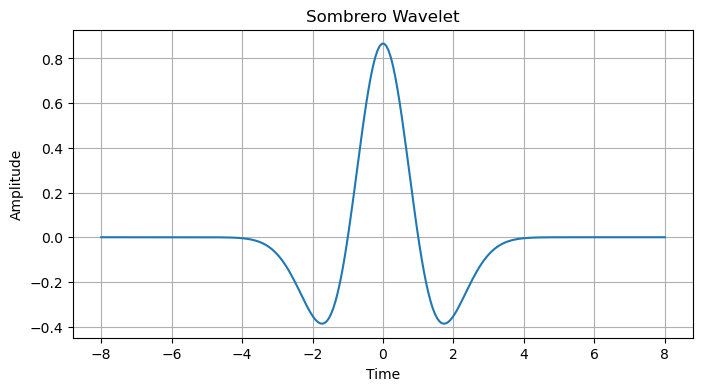

In [68]:
sombrero = pywt.ContinuousWavelet('mexh')
print(sombrero)

#plot the wavelet
plt.figure(figsize=(8, 4))
sombrero_wavelet = sombrero.wavefun()
plt.plot(sombrero_wavelet[1], sombrero_wavelet[0])
plt.title("Sombrero Wavelet")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

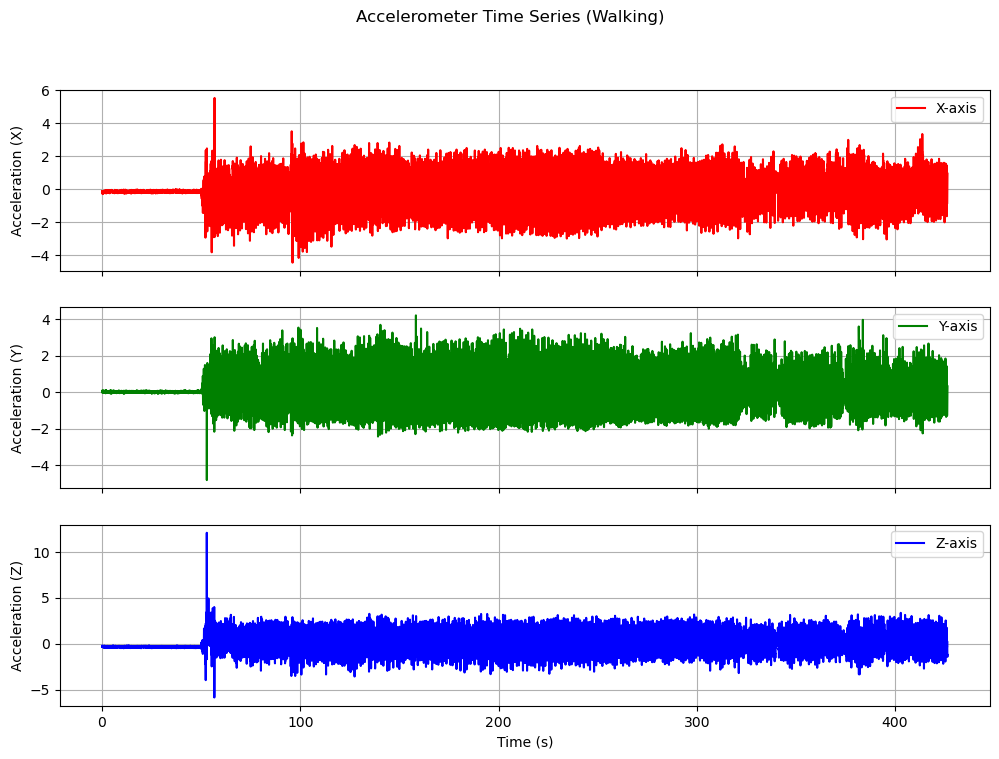

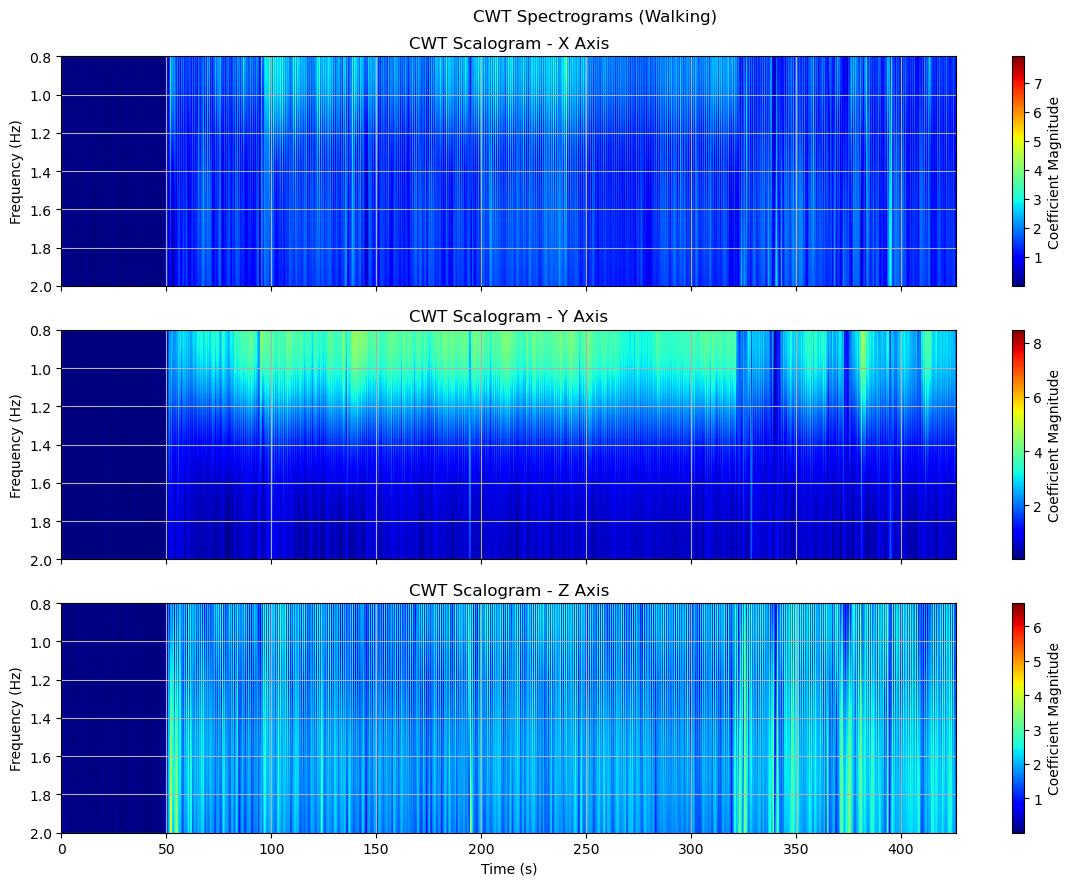

In [69]:
# plot the time series data for the activity of walking
walking = data[data['Label'] == 4]
walking = preprocess_data(walking)
plot_time_series(walking, "Walking")
# plot the CWT spectrograms for the activity of walking
plot_cwt_spectrograms(walking, sombrero, "Walking", freq_min=0.8, freq_max=2)


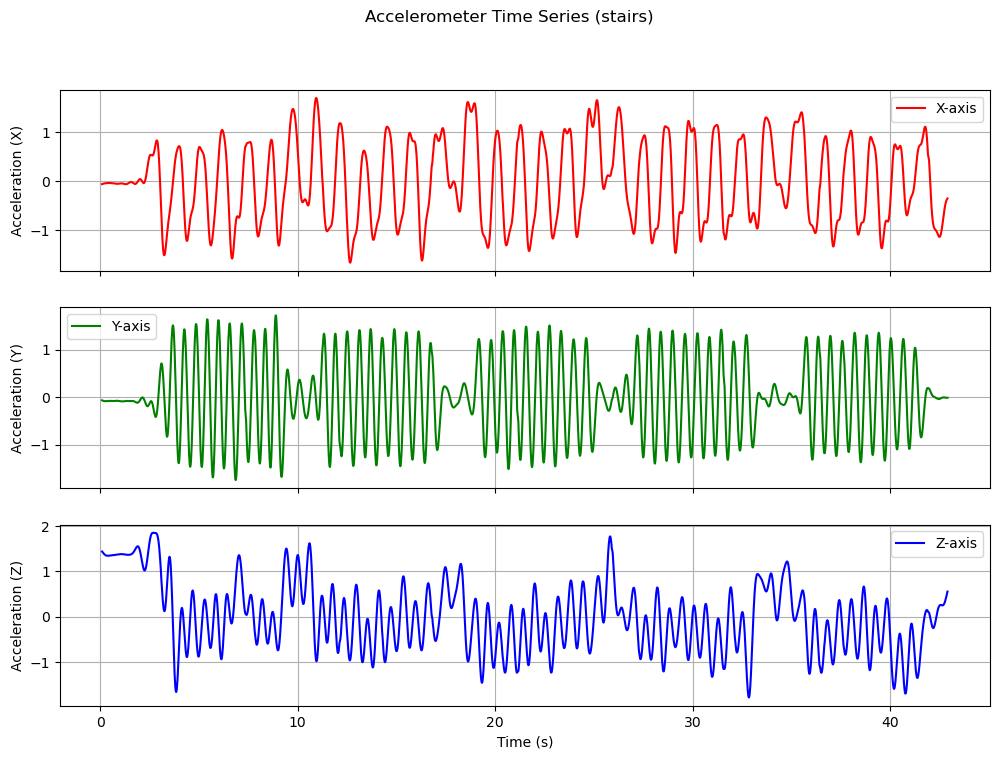

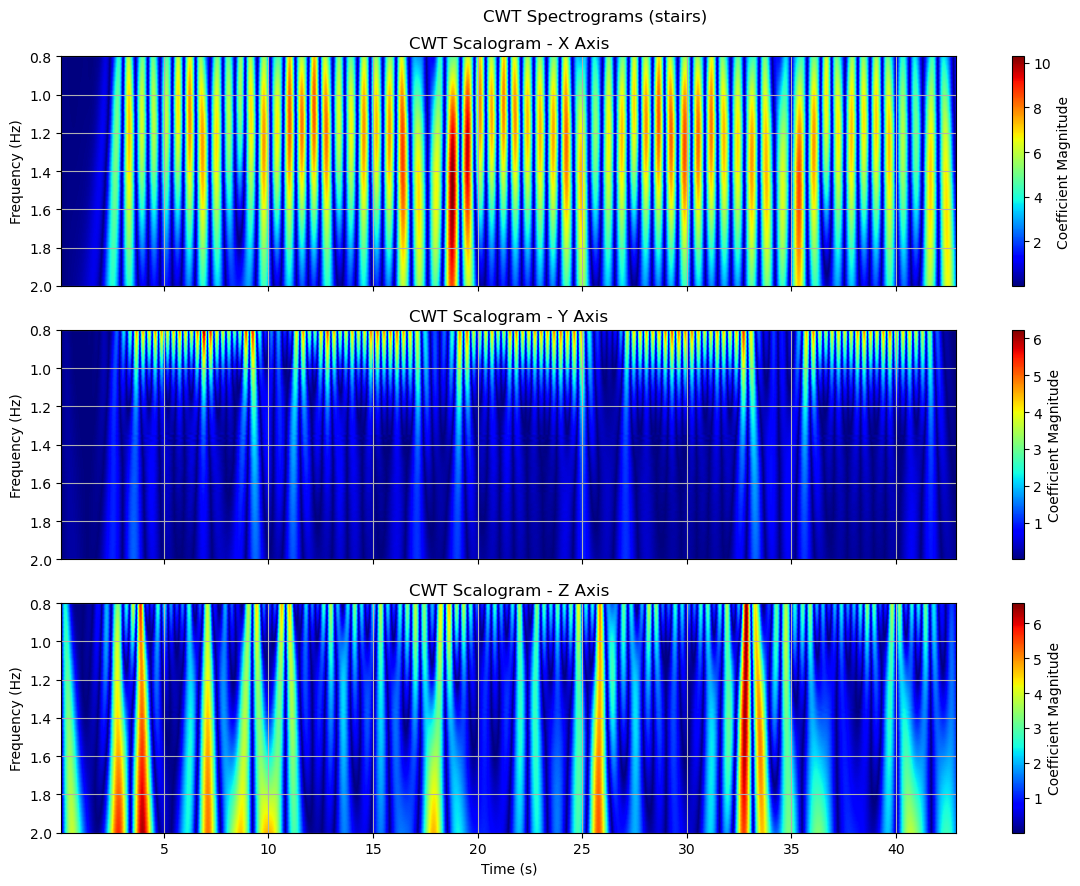

In [73]:
# Load the data from the CSV file
data_walking = pd.read_csv(f'./dataset/stairs.csv')

# Clean the data
CUTOFF_FREQ = 2
data_walking = preprocess_data(data_walking, low_pass=True, low_pass_freq=2)

# Plot the time series data for the activity of walking
plot_time_series(data_walking, "stairs")

# Plot the CWT spectrograms for the activity of walking
plot_cwt_spectrograms(data_walking, sombrero, "stairs", fs=100 ,freq_min=0.8, freq_max=2)